In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
words = open('names.txt','r').read().splitlines()
words[:5]


['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [10]:
len(words)

32033

In [11]:
# building the vocabulary with mapping from characters to integers and vice-versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [12]:
# building the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # cropping and appending

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [13]:
n_embd = 10
n_hidden = 200



g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)

# W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * 0.2 # improvement 2
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size)**0.5) 
b1 = torch.randn(n_hidden, generator = g) * 0.01 # improvement 2
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01  # improvement. not exactly 0
b2 = torch.randn(vocab_size, generator = g)* 0 # improvement

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
# at initialization, we will have unit gaussian


parameters = [C, W1, b1, W2, b2, bngain, bnbias] 
print(sum(p.nelement() for p in parameters)) # getting the number of parameters
for p in parameters:
    p.requires_grad = True

12297


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # FORWARD PASS

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  # pre activation. b1 will be negated so there is no point adding it here. bnbias is more in charge. We don't need b1 anymore

    # normmalizing hpreact
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    # we also scale and shift because we dont want an exact gaussian
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    # upgrading the running mean and std, using a LC of current and previous values
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001* bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    
    h =  torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # BACKWARD PASS

    for p in parameters:
        p.grad = None
    loss.backward()

    # update 

    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i %10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())  # log loss looks nicer, usual loss looks like a hockey stick

print(loss.item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.2950
  30000/ 200000: 2.3937
  40000/ 200000: 1.9780
  50000/ 200000: 2.4495
  60000/ 200000: 2.4431
  70000/ 200000: 2.0071
  80000/ 200000: 2.2948
  90000/ 200000: 2.1144
 100000/ 200000: 2.0097
 110000/ 200000: 2.3772
 120000/ 200000: 2.0301
 130000/ 200000: 2.4808
 140000/ 200000: 2.4385
 150000/ 200000: 2.2068
 160000/ 200000: 2.0353
 170000/ 200000: 1.8832
 180000/ 200000: 2.0849
 190000/ 200000: 1.8312
2.486149549484253


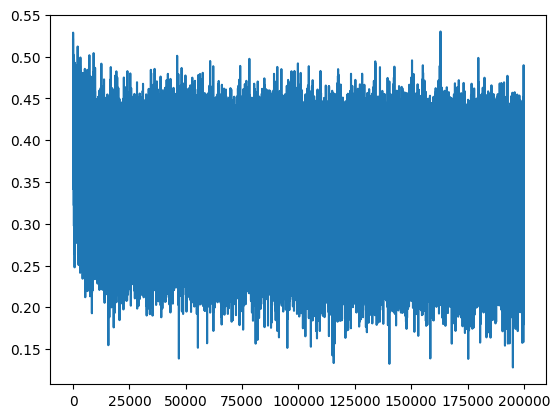

In [15]:
plt.plot(lossi)

In [16]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat@W1 + b1
    # measure the mean/std over the entire traning set
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)

# we can see that bnmean and bnmean_running are pretty close to each other. So we can use the running one

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    hpreact = embcat@W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1111013889312744
val 2.137741804122925


In [18]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        hpreact  = emb.view(1, -1) @ W1 + b1
        hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h@W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

carlah.
ambrilli.
kimley.
taty.
sacessa.
jazonte.
den.
art.
kaeli.
nellara.
chaiiv.
kaleigh.
ham.
join.
quinn.
salin.
alvin.
quinathoniearyxi.
jaxen.
dustine.


In [19]:
# IMPROVEMENTS
# 1. loss at 0 is too high. This could be because of how we are initalizing the parameters 
# 2. the output of h is at extremes, which means the input values are also extreme. Which is because hpreact is at extremes. Then grad at this level is very low (~0)

# NOTES
# Multiplication of one normal distribution matrix with another unit one results in a higher standard deviation. Based on the activation function, there are ratios that you multiply the initializations with. (Look up kaiming init)
# We dont neeed to initialize that well now, owing to batch normalization. Just take the hidden states and normalize them to be Gaussian. One problem with batch normalization is that outputs for an example are not just dependent on that example, but for other samples in the batch (While this entropy is sometimes desirable, there have been methods which bypass it ). 


## pytorchifying the neural network

In [73]:
# defining classes for linear and batchnorm
# We will create classes close to what is there in pytorch

class Linear:
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)       # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers:
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_Var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # dimensionality if character embedding vectors
n_hidden = 100  # number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)    

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer; make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1 # since the last layer is now a batchnorm
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
        
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))    # number of parameters in total
for p in parameters:
    p.requires_grad = True




47551


In [74]:
# model training

max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio. See how much parameters are getting changed

for i in range(max_steps):

    # constructing the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i %10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())  # log loss looks nicer, usual loss looks like a hockey stick

    with torch.no_grad():
        ud.append([(lr*p.grad.std()/ p.data.std()).log10().item() for p in parameters])
        # how great are the updates to the tensors
    
    if i >=1000:

        break
        

      0/ 200000: 3.2974


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.19%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.56%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.06%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.75%


Text(0.5, 1.0, 'activation distribution')

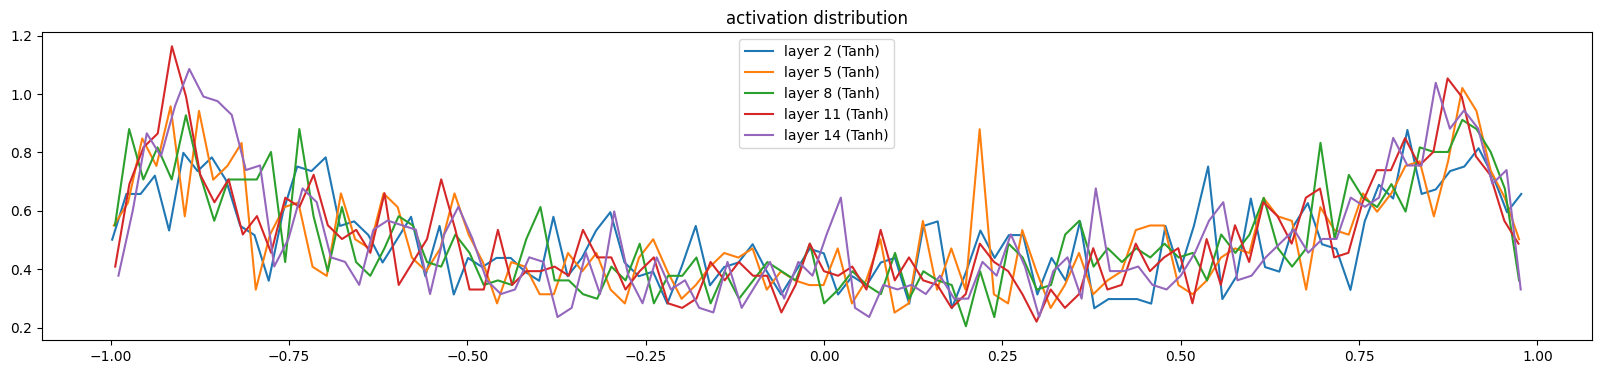

In [75]:
# visualize histograms

# ACTIVATION STATISTICS FOR THE FORWARD PASS

plt.figure(figsize = (20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer since no tanh activation
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

# highlights the need for gains in forward pass

layer 2 (      Tanh): mean -0.000000, std 3.104397e-03
layer 5 (      Tanh): mean +0.000000, std 2.486357e-03
layer 8 (      Tanh): mean +0.000000, std 2.369178e-03
layer 11 (      Tanh): mean -0.000000, std 2.262487e-03
layer 14 (      Tanh): mean -0.000000, std 2.287373e-03


Text(0.5, 1.0, 'activation distribution')

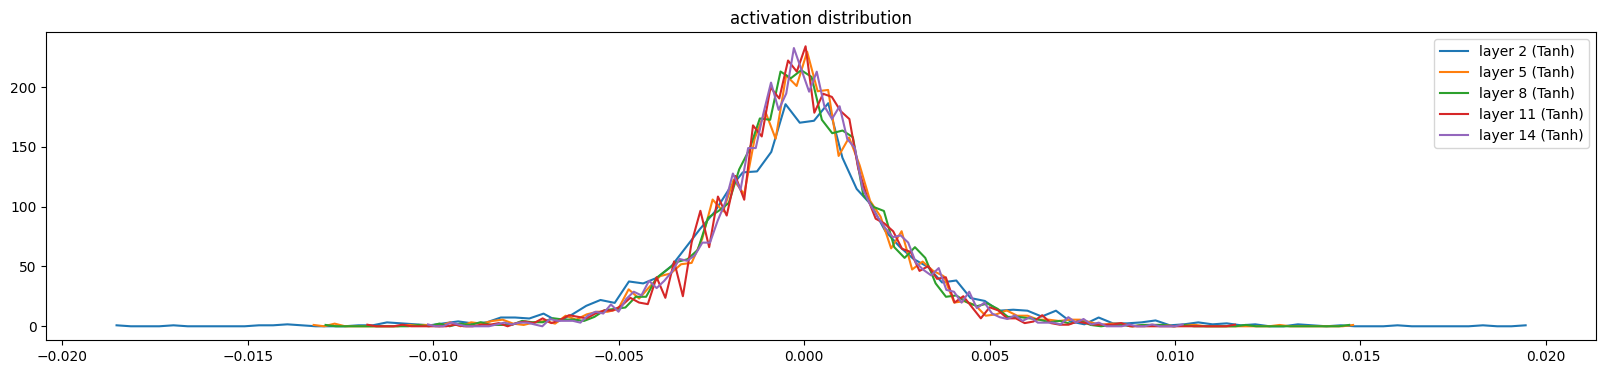

In [76]:
# visualize histograms
# ACTIVATION STATISTICS FOR THE BACKWARD PASS

plt.figure(figsize = (20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer since no tanh activation
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

# highlights the need for gains in backward pass

weight   (27, 10) | mean +0.000000 | std 1.034569e-02 | grad:data ratio 1.053131e-02
weight  (30, 100) | mean +0.000130 | std 7.708201e-03 | grad:data ratio 2.499465e-02
weight (100, 100) | mean +0.000010 | std 6.201431e-03 | grad:data ratio 3.687640e-02
weight (100, 100) | mean +0.000007 | std 5.392718e-03 | grad:data ratio 3.220333e-02
weight (100, 100) | mean +0.000046 | std 5.179550e-03 | grad:data ratio 3.089342e-02
weight (100, 100) | mean -0.000056 | std 4.908013e-03 | grad:data ratio 2.909318e-02
weight  (100, 27) | mean +0.000122 | std 9.658923e-03 | grad:data ratio 5.796977e-02


Text(0.5, 1.0, 'activation distribution')

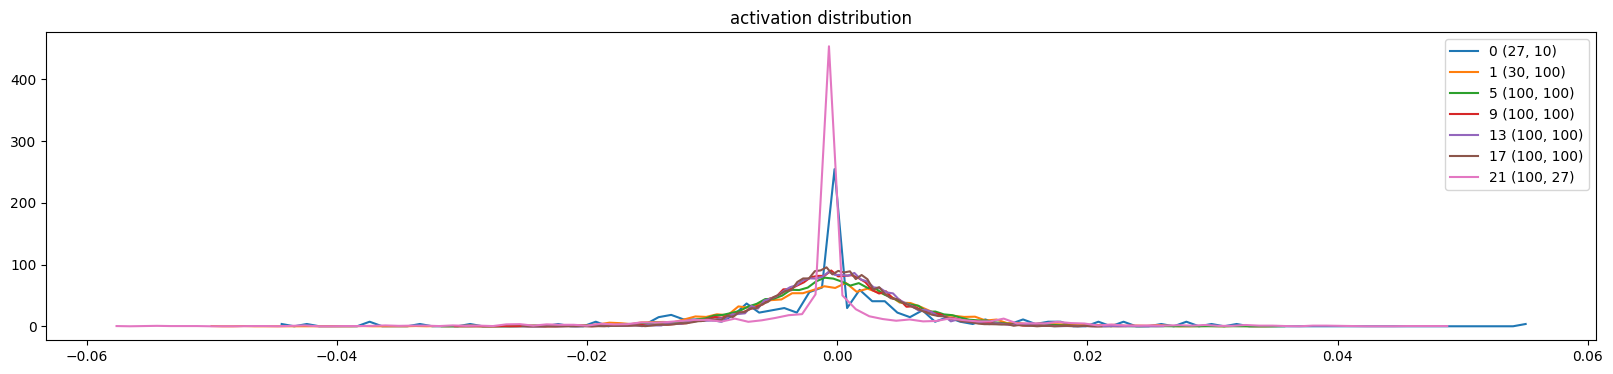

In [77]:
# visualize histograms
# ACTIVATION STATISTICS FOR THE BACKWARD PASS

plt.figure(figsize = (20, 4))
legends = []

for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim == 2:
        
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('activation distribution')

# highlights the need for gains in backward pass

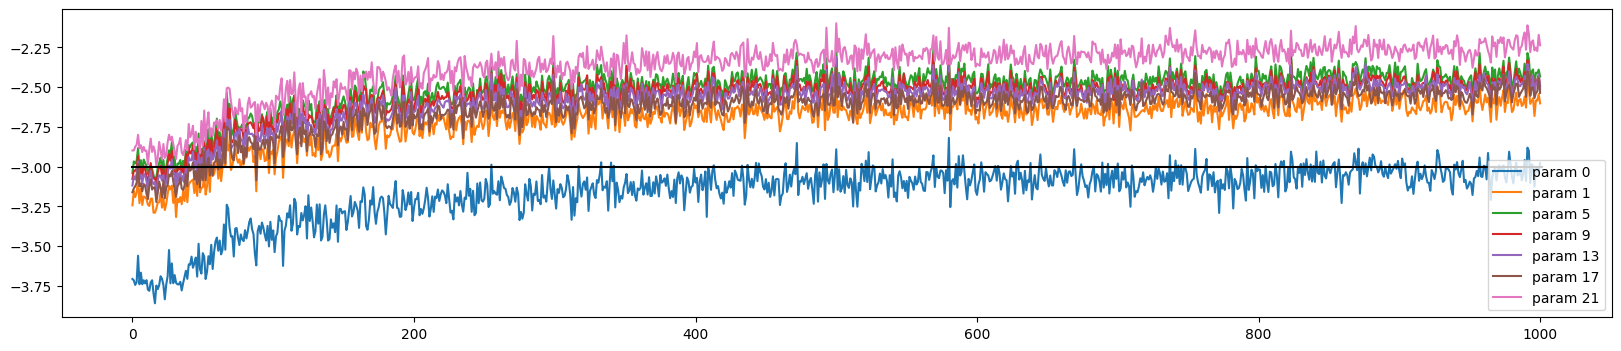

In [78]:
# visualize histograms
# ACTIVATION STATISTICS FOR THE BACKWARD PASS

plt.figure(figsize = (20, 4))
legends = []

for i, p in enumerate(parameters): 
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' %i)
plt.plot([0, len(ud)], [-3, -3], 'k')   # these ratios should be ~1e-3 
plt.legend(legends)


# the ratio is high for the last layer, mainly because we initialize those weights to be low
